# Autoencoder para reducción de ruido

El modelo es tomado de [GuitarsAI](https://github.com/GuitarsAI) https://www.youtube.com/watch?v=gVFCX-olr-M

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
from pydub import AudioSegment

In [2]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


In [5]:
os.chdir("../Audios")
wd=os.getcwd()
wd_norm=os.listdir('mp3/Normal')
wd_sarc=os.listdir('mp3/Sarcasmo')

## Pasar de mp3 a wav

Aqui hay un problema, no esta leyendo el audio 35, ni 36, no sé si de ahí en adelante tampoco

In [6]:
for audio in wd_norm:
    # files                                                                         
    src = "mp3/Normal/"+audio
    dst = "wav/Normal_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt --enable-amf
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
[mp3 @ 0000023c9a0d5380] Failed to read frame size: Could not seek to 11542.
mp3/Normal/Audio_35.mp3: Invalid argument


In [12]:
from IPython.display import Audio
display(Audio('mp3/Normal/Audio_35.mp3'))

Aquí tambien hay problemas, el audio 100 no lo está leyendo

In [9]:
for audio in wd_sarc:
    # files                                                                         
    src = "mp3/Sarcasmo/"+audio
    dst = "wav/Sarcasmo_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt --enable-amf
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
[mp3 @ 0000027f441d5380] Failed to read frame size: Could not seek to 5867.
mp3/Sarcasmo/Audio_100.mp3: Invalid argument


In [10]:
display(Audio('Sarcasmo/Audio_100.mp3'))

ValueError: rate must be specified when data is a numpy array or list of audio samples.

Con uno de los audios que si se pasaron a .wav mire algo del procesamiento de audios tomado de [Beginner's Guide to Audio Data](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data). Los siguientes gráficos son del audio crudo (1D array) 

In [13]:
display(Audio('wav/Normal_wav/Audio_1.wav'))

In [15]:
# scipy
from scipy.io import wavfile
rate, data = wavfile.read("wav/Normal_wav/Audio_1.wav")
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (281088, 2)
[[   0    0]
 [   0    0]
 [   0    0]
 ...
 [  -8   -8]
 [ -59  -59]
 [-114 -114]]


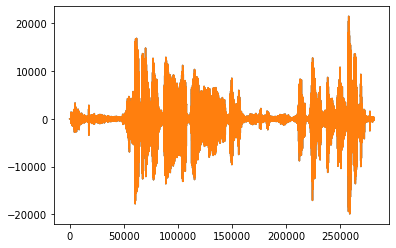

In [16]:
#Gráfico de los frames(marcos) del audio
plt.plot(data, '-', );

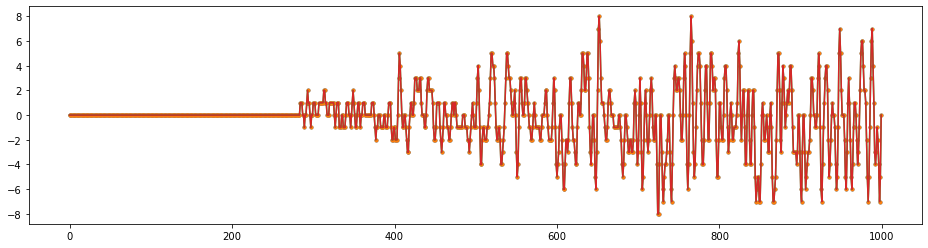

In [17]:
#Zoom en los primeros 1000 frames
plt.figure(figsize=(16, 4))
plt.plot(data[:1000], '.'); plt.plot(data[:1000], '-');

## Con audios en MP3

In [19]:
y, sr = librosa.load("mp3/Normal/Audio_1.mp3")
librosa.feature.melspectrogram(y=y, sr=sr)

array([[1.4124211e-04, 6.4624433e-04, 2.0889274e-03, ..., 2.6005891e-03,
        8.9461607e-04, 6.6318811e-04],
       [2.1077051e-04, 8.7722071e-04, 2.4391920e-03, ..., 1.4399672e-03,
        7.1109453e-04, 1.7961246e-03],
       [2.7493734e-04, 6.7092339e-04, 9.4860344e-04, ..., 2.6280112e-03,
        1.3145994e-03, 1.8213964e-03],
       ...,
       [1.7611904e-09, 9.3290134e-07, 8.9800005e-06, ..., 2.6329698e-09,
        2.8371492e-08, 8.7693945e-07],
       [8.1298412e-10, 3.4993195e-07, 2.6490550e-06, ..., 2.6378224e-09,
        2.4373136e-08, 7.6044637e-07],
       [4.5773423e-11, 2.9024948e-08, 2.8090284e-07, ..., 1.6430654e-10,
        1.5182454e-08, 5.0437274e-07]], dtype=float32)

In [20]:
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

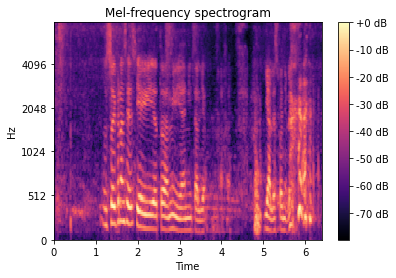

In [21]:
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [22]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [23]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [26]:
batch=1
audio, samplerate = librosa.load("mp3/Normal/Audio_1.mp3", mono=False, sr=None, offset=6)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension    
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

In [27]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
print(Y.device)

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 16386
Input X.shape= torch.Size([1, 1, 16488])
Target Y.shape= torch.Size([1, 1, 16386])
Target Y= tensor([[[-0.3389, -0.3659, -0.3847,  ...,  0.0043, -0.0045, -0.0097]]])
Y.type()= torch.FloatTensor
cpu


In [28]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(4000):
        #distortions: shift and noise:
        #"""
        Xlast=X_train[:,:,-1].clone() 
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone() 
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
        #"""
        Ypred=model(X_train+torch.randn(X_train.size()).to(device)*0.05)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[ 0.0253, -0.0018,  0.0335,  ...,  0.0184,  0.0199,  0.0191]]],
       grad_fn=<SqueezeBackward1>)
0 0.025260740891098976
10 0.024027477949857712
20 0.023317813873291016
30 0.023167984560132027
40 0.02065325900912285
50 0.016120944172143936
60 0.015267586335539818
70 0.016088038682937622
80 0.014787241816520691
90 0.011561838909983635
100 0.010503328405320644
110 0.01129861269146204
120 0.011162812821567059
130 0.010079552419483662
140 0.009296664036810398
150 0.009707994759082794
160 0.009544676169753075
170 0.009255518205463886
180 0.008728948421776295
190 0.009007134474813938
200 0.008954517543315887
210 0.00879831425845623
220 0.008729861117899418
230 0.008629465475678444
240 0.008878004737198353
250 0.008495199494063854
260 0.008656985126435757
270 0.008597306907176971
280 0.008685496635735035
290 0.008391802199184895
300 0.008292081765830517
310 0.008544672280550003
320 0.008278967812657356
330 0.008329123258590698
340 0.007996601983904839
350 0.008164806291460991

ww= OrderedDict([('conv1.weight', tensor([[[-0.0136, -0.0182, -0.0127,  ..., -0.0044, -0.0094,  0.0291]],

        [[-0.0537, -0.0383, -0.0414,  ..., -0.0173, -0.0020, -0.0225]],

        [[ 0.0005, -0.0071, -0.0019,  ..., -0.0251, -0.0241, -0.0317]],

        ...,

        [[-0.0172, -0.0312, -0.0205,  ...,  0.0347,  0.0329,  0.0203]],

        [[-0.0114, -0.0104,  0.0070,  ..., -0.0017, -0.0116, -0.0223]],

        [[ 0.0065,  0.0186,  0.0096,  ..., -0.0022,  0.0149, -0.0059]]])), ('conv1.bias', tensor([ 3.4601e-04, -5.8248e-04, -2.2444e-03, -3.4340e-03,  1.6282e-03,
         7.9534e-05,  5.1001e-03,  1.7256e-04, -7.6477e-03, -1.7616e-03,
        -6.6461e-03,  5.9360e-03, -1.2833e-03, -3.9187e-03,  1.3630e-02,
         8.3585e-04, -2.0530e-03, -5.7573e-03,  5.5980e-03,  3.3381e-03,
         6.3104e-03, -2.6072e-04,  2.2341e-03, -3.7166e-03, -2.6865e-03,
        -2.9114e-03, -2.1229e-03, -9.5906e-03,  1.3234e-03,  3.2348e-03,
         3.6658e-03,  4.9477e-03])), ('synconv1.weight', te

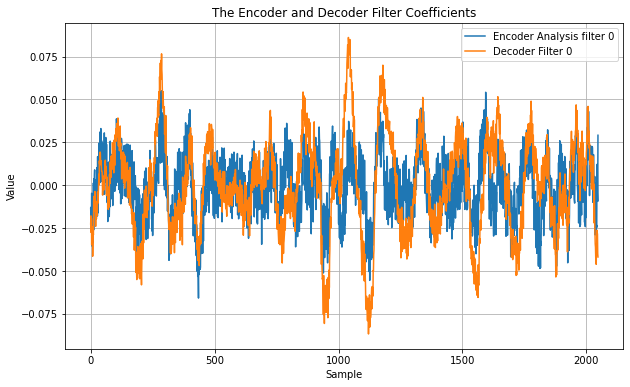

In [29]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.cpu().state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

(1, 1, 16386)
predictions.shape= (1, 1, 16386)


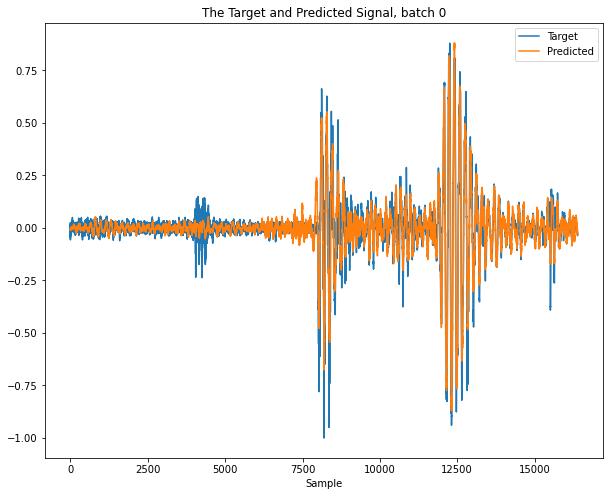

In [30]:
#Test on training set:
Xnoise=(X_train+torch.randn(X_train.size()).to(device)*0.05)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(Xnoise.cpu()) # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y.cpu()) #target
print(Y.shape)
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(Y[b,0,:])
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()

Xnoise=Xnoise.detach()
Xnoise=np.array(Xnoise.cpu())
xnoise=Xnoise[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)
    
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [31]:
torch.randn(X_train.size()).device

device(type='cpu')

In [32]:
import IPython.display as ipd
display(ipd.Audio(xnoise, rate=samplerate));

In [33]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

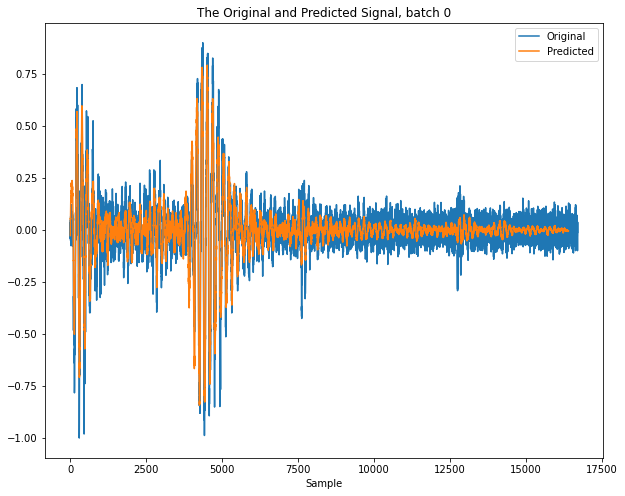

In [34]:
#Test on Verification set:
X_test_shifted_100 = nn.ConstantPad1d(100, 0)(X_test)
x=X_test_shifted_100.cpu()+torch.from_numpy((np.random.normal(scale=0.04, size=X_test_shifted_100.shape))).float()
predictions=model(x) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(x[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [35]:
display(ipd.Audio(x[:,0,:], rate=samplerate))

In [36]:
display(ipd.Audio(xrek, rate=samplerate))